## Print Start time

In [2]:
import time
print("------------------------------------------------")
print("Start-Time")
# print current time in format: 2019-10-03 13:10:00
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
print("------------------------------------------------")


2024-03-21 19:19:12


In [4]:
import os
print("Does df-save-path exist:", os.path.exists('data/augmented_train_dfs'))

Does df-save-path exist: True


## Load df

In [10]:
import pandas as pd

df = pd.read_csv('data/SMM4H_2024_Task3_Training_1800.csv', usecols=['keyword', 'text', 'label'])

print(df)

                                    keyword  \
0                                       run   
1                                   outside   
2                          run, swim, climb   
3                                      walk   
4                                   outside   
...                                     ...   
1795                     pool, beach,  pool   
1796                     outside , outdoors   
1797                                Jogging   
1798                  walk, swimming,  pool   
1799  roller blade, outside , roller blades   

                                                   text  label  
0     21/m. I want to experience young love, but I'v...      0  
1     Having issues talking to a girl whom I enjoyed...      0  
2     Need some advice for free social activities. I...      0  
3      I spoke to her today.. A few weeks ago I met ...      0  
4     How to get over Social Anxiety?. Hello, The ot...      0  
...                                          

## Do imports

In [11]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
# !pip install datasets
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

ModuleNotFoundError: No module named 'transformers'

## Clean text

In [12]:
def clean_text(text):
    import re
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['text'] = df['text'].apply(clean_text)

## Add Keywords to text

In [13]:
df['text'] = df['keyword'] + " " + df['text']

## Split data

In [14]:
from sklearn.model_selection import train_test_split

# First, split the data into a training set and a temporary set (which will be further split into validation and test sets)
train_texts, temp_texts, y_train, temp_labels = train_test_split(df['text'], df['label'], test_size=0.4, random_state=42)

# Next, split the temporary set into validation and test sets
val_texts, test_texts, y_val, y_test = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

## Cut Classes to X texts

In [15]:
# Create a DataFrame from the training texts and labels
train_df = pd.DataFrame({'text': train_texts, 'label': y_train})

# Sample 200 texts from each class (or as many as are available for classes with fewer than 200 examples)
sampled_dfs = []
for label in train_df['label'].unique():
    class_sample_size = min(len(train_df[train_df['label'] == label]), 400)
    sampled_dfs.append(train_df[train_df['label'] == label].sample(n=class_sample_size, random_state=42))

# Concatenate the samples to create a balanced training DataFrame
train_df = pd.concat(sampled_dfs, ignore_index=True)

label
unrelated    400
neutral      231
positive      97
negative      71
Name: count, dtype: int64


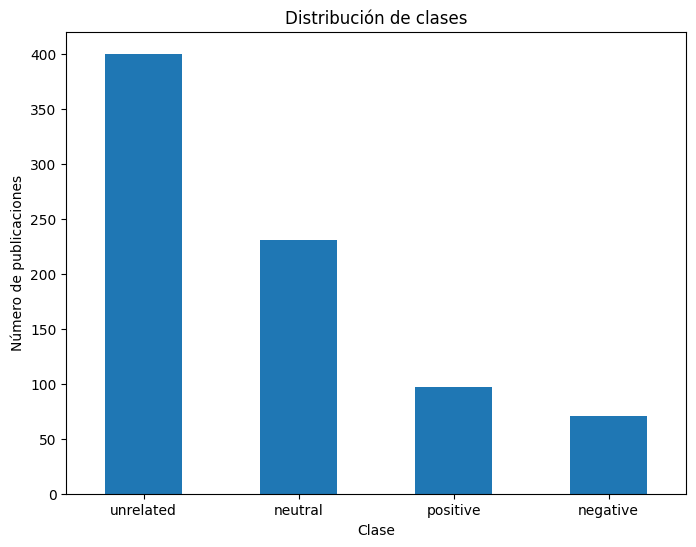

In [ ]:
# import matplotlib.pyplot as plt

# df_plot = balanced_train_df.copy()

# label_mapping = {1: 'positive', 2: 'neutral', 3: 'negative', 0: 'unrelated'}
# df_plot['label'] = df_plot['label'].map(label_mapping)

# # Contar el número de publicaciones en cada categoría
# class_counts = df_plot['label'].value_counts()
# print(class_counts)

# # Crear un gráfico de barras
# plt.figure(figsize=(8, 6))
# class_counts.plot(kind='bar')
# plt.title('Distribución de clases')
# plt.xlabel('Clase')
# plt.ylabel('Número de publicaciones')
# plt.xticks(rotation=0)
# plt.show()

## Backtranslate

In [1]:
backtranslate = True

if backtranslate:

    from utils import backtranslation

    for label in {1, 3}:
        print(f"Backtranslating class {label}...")
        # Backtranslate and augment the data for underrepresented classes
        selected_texts = train_df[train_df['label'] == label]['text']
        print(f"length texts of label {label}", len(selected_texts))
        augmented_texts = backtranslation.backtranslate(selected_texts.to_list())
        augmented_df = pd.DataFrame({'text': augmented_texts, 'label': [label] * len(augmented_texts)})
        augmented_df.to_csv(f'data/augmented_train_dfs/backtranslated_class_{label}.csv', index=False)
        train_df = pd.concat([train_df, augmented_df])

    # Check the new class distribution after backtranslation
    print("Class distribution after backtranslation:", train_df['label'].value_counts())

    # Save the augmented training dataframe to a CSV file
    train_df.to_csv(f'data/augmented_train_dfs/train_df_plus_backtranslated_class_1_3.csv', index=False)


ModuleNotFoundError: No module named 'transformers'

## Load train_df from csv

In [ ]:
# If we don't backtranslate, load the existing augmented training DataFrame
if not backtranslate:
    train_df = pd.read_csv('data/augmented_train_dfs/bcktrn_class_1_3_to_200.csv')

## Split train_df into texts and labels

In [ ]:
# Now you can extract the texts and labels
train_texts = train_df['text']
print("Train texts balanced", train_texts)
y_train = train_df['label']
print("y_train balanced", y_train)

## Run Model

In [ ]:
from models import tune_transformer

model = 'DistilBert'
# model = 'RoBERTa'

if model == 'DistilBert':
    tune_transformer.run('distilbert-base-uncased', train_texts, val_texts, test_texts, y_train, y_val, y_test)
elif model == 'RoBERTa':
    tune_transformer.run('roberta-base', train_texts, val_texts, test_texts, y_train, y_val, y_test)

## Print End Time

In [ ]:
import time
print("------------------------------------------------")
print("End-Time")
# print current time in format: 2019-10-03 13:10:00
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
print("------------------------------------------------")


## Tokenize data and create Datasets

In [ ]:
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# # Tokenize and encode the text data
# def tokenize_data(texts, labels):
#     encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
#     return {"input_ids": encodings["input_ids"], "attention_mask": encodings["attention_mask"], "labels": labels}

# train_encodings = tokenize_data(train_texts.to_list(), y_train.to_list())
# val_encodings = tokenize_data(val_texts.to_list(), y_val.to_list())
# test_encodings = tokenize_data(test_texts.to_list(), y_test.to_list())

# # Convert to Hugging Face Dataset
# train_dataset = Dataset.from_dict(train_encodings)
# val_dataset = Dataset.from_dict(val_encodings)
# test_dataset = Dataset.from_dict(test_encodings)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Load Model

In [ ]:
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)  # Assuming 4 classes

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define Compute Metrics

In [ ]:
# import numpy as np


# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
#     acc = accuracy_score(labels, predictions)
#     return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


## Define Training Arguments

In [ ]:
# training_args = TrainingArguments(
#     output_dir='./results',
#     num_train_epochs=3,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     warmup_steps=500,
#     weight_decay=0.01,
#     learning_rate=5e-5,
#     logging_dir='./logs',
#     logging_steps=10,
#     evaluation_strategy="epoch"
# )

In [ ]:
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
#     compute_metrics=compute_metrics
# )

In [ ]:
# trainer.train()

In [ ]:
# test_results = trainer.predict(test_dataset)
# print("Test results:", test_results.metrics)

# print("(True) Test Labels):", test_results.label_ids)

In [ ]:
# from sklearn.metrics import classification_report
# import numpy as np

# test_pred_labels = np.argmax(test_results.predictions, axis=-1)
# print("Predicted Labels", test_pred_labels)

# # Generate and print the classification report
# print(classification_report(y_test, test_pred_labels, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3']))